In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

%matplotlib notebook

## Simulated data for block trial structure

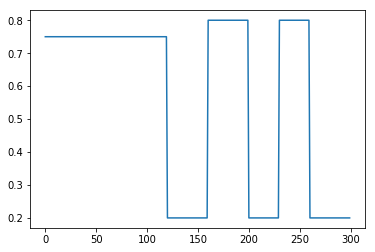

In [2]:
# Generate fake data from the model
# Build the true reward rate
true_prob = [0.75] * 120 + [0.2] * 40 + [0.8] * 40 + [0.2] * 30 + [0.8] * 30 + [0.2] * 40
plt.plot(true_prob)

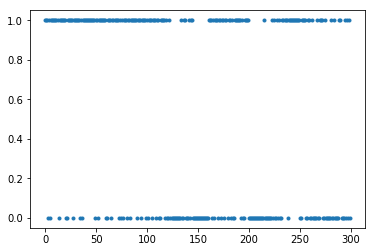

In [3]:
# Generate data from bernoulli
randvars = np.random.random(len(true_prob))
outcomes = randvars < true_prob
plt.figure()
plt.plot(outcomes, '.')

## Exact inference

In [4]:
# Define some conditionals that will be useful
def pr_next(rnext, rprev, v):
    '''Find p(r_{i+1} = rnext | r_i = rprev, v)'''
    # Take care of boundaries:
    if rnext == 0:
        rval = 1e-10
    elif rnext == 1:
        rval = 1 - 1e-10
    else:
        rval = rnext
                  
    s = rprev * np.exp(-v)
    n = (1 - rprev) * np.exp(-v)
    
    if s == 0:
        s = 1e-10
    if n == 0:
        n = 1e-10
    
    #print(s, n)
    return sts.beta.pdf(rval, s, n)

def pv_next(vnext, vprev, k):
    '''Find p(v_{i+1} = vnext | v_i = vprev, k)'''
    K = np.exp(k)
    return sts.norm.pdf(vnext, vprev, K)

def py_given_r(y, r):
    '''p(y = y| r), which is bernoulli'''
    if y == 1:
        return r
    else:
        return 1 - r

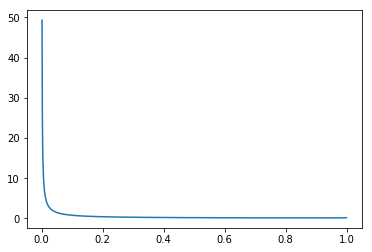

In [5]:
xvals = np.linspace(0, 1, 1000)
y = sts.beta.pdf(xvals, 0.1, 0.9)
plt.figure()
plt.plot(xvals,y)

In [6]:
# Set up a grid of r, v, k
rvals = np.linspace(0, 1, 10)
vvals = np.linspace(0, 5, 10)
kvals = np.linspace(0, 5, 10)
rgrid, vgrid, kgrid = np.meshgrid(rvals, vvals, kvals, indexing='ij')

# Set up the probability grid
posterior_arr = np.ones_like(rgrid)

In [7]:
# Use recursion to find the posterior
def find_posterior(r, v, k, y, i):
    '''Find the posterior p(r_{i+1}, v_{i+1}, k | y_{<=i+1})
    Inputs:
    - r: value of r_{i+1}
    - v: value of v_{i+1}
    - k: value of k
    - y: array of y responses
    - i: time point'''
    
    #print(r, v, k, i)
    dv = (np.max(vvals) - np.min(vvals)) / len(vvals)
    dr = (np.max(rvals) - np.min(rvals)) / len(rvals)
    # Base case
    if i == -1:
        return 1 # Uniform prior
    
    # Recursive step
    p_yr = py_given_r(y[i], r)
    
    # Do the integral
    integral = 0
    for ri in rvals:
        p_rv = pr_next(r, ri, v)
        #print('p_rv:', r, ri, v, p_rv)
        
        # Inner integral
        inner = 0
        for vi in vvals:
            p_vk = pv_next(v, vi, k)
            posterior_prev = find_posterior(ri, vi, k, y, i - 1)
            inner += posterior_prev * p_vk * dv
    
        integral += inner * p_rv * dr
        
    #print('Results for ', r, v, k, i, ': ', integral)
    return integral * p_yr
    

In [8]:
for i, r1 in enumerate(rvals):
    for j, v1 in enumerate(vvals):
        for m, k1 in enumerate(kvals):
            posterior_arr[i, j, m] = find_posterior(r1, v1, k1, [0], 0)
            

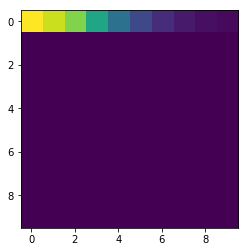

In [9]:
plt.imshow(posterior_arr[:,9,:])